# Location Intelligence Data Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from shapely.geometry import Point

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from scipy.spatial import distance
from scipy.cluster import hierarchy

import geopandas as gpd

In [2]:
X_train = pd.read_csv('./DATA/X_train.csv')
X_val = pd.read_csv('./DATA/X_val.csv')
X_train_lat_long = pd.read_csv('./DATA/X_train_lat_long.csv')
X_val_lat_long = pd.read_csv('./DATA/X_val_lat_long.csv')

## Modelling

In [3]:
def metrics_plots(X, max_k=10):
    score = []
    score_kmeans_s = []
    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state= 101)
        predictions = kmeans.fit_predict(X)
        score.append(kmeans.score(X))
        score_kmeans_s.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))
        score_kmeans_c.append(calinski_harabasz_score(X, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(X, predictions))

    list_scores = [score, score_kmeans_s, score_kmeans_c, score_kmeans_d] 
    list_title = ['Within-cluster sum of squares', 'Silhouette Score', 'Calinski Harabasz', 'Davies Bouldin'] 
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

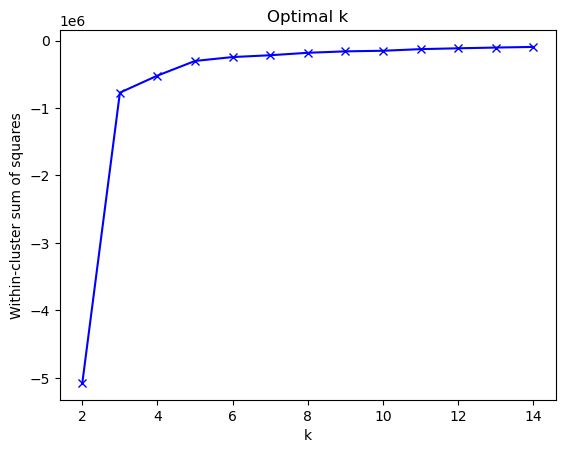

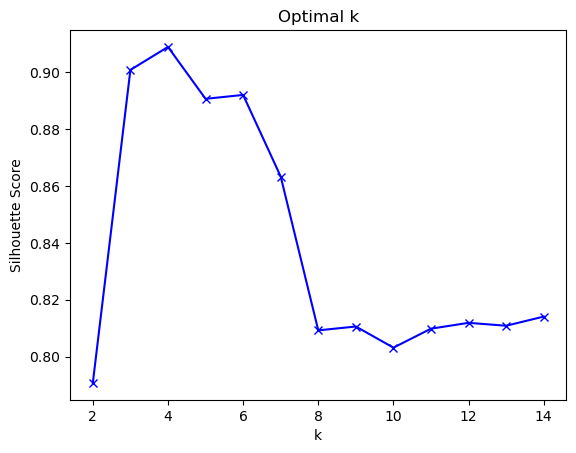

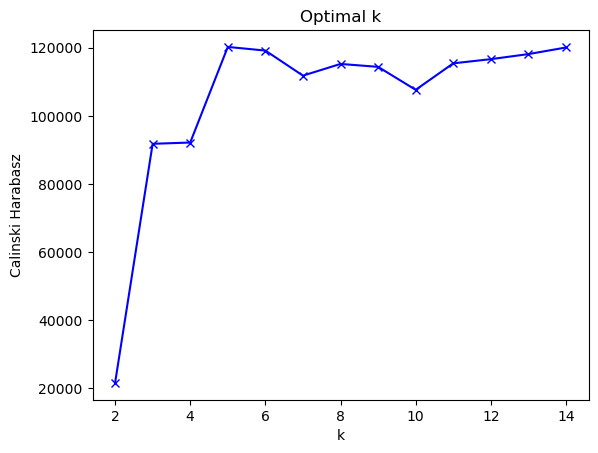

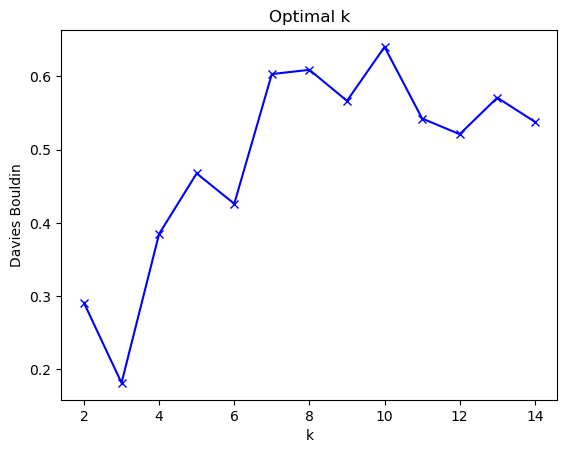

In [4]:
metrics_plots(X_train, max_k=15)

#### Results functions

In [116]:
def createColorMap(labels):
    unique_labels = np.unique(labels)
    cmap = cm.get_cmap('viridis', len(unique_labels))
    category_colors = {label: cmap(i) for i, label in enumerate(unique_labels)}
    return category_colors

def drawMap(data, labels, category_colors):
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(X_train_lat_long['longitude'], X_train_lat_long['latitude']))
    
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world[(world.name != "Antarctica")]
    

    fig, ax = plt.subplots(figsize=(15, 7))
    world.plot(ax=ax, color='lightgray', edgecolor='white')
    
    for label, color in category_colors.items():
        subset = gdf[labels == label]
        subset.plot(ax=ax, marker='o', color=color, markersize=9, label=label)
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=9) 
                       for label, color in category_colors.items()]
    
    ax.legend(handles=legend_elements, loc='upper right', title='Cluster')
    
    plt.title('Businesses on World Map')
    plt.show()

def CountClusters(labels, category_colors):
    df = pd.DataFrame({"labels": labels})
    value_counts = df["labels"].value_counts()
        
    counts = value_counts.values
    clusters = value_counts.index

    plt.figure(figsize=(15, 6))
    bars = plt.bar(clusters, counts, color=[category_colors[c] for c in clusters])
    plt.title('Distribution of Clusters')
    plt.xlabel('Cluster Number')
    plt.ylabel('Number of Businesses')
    plt.show()

def calculateScores(data, labels):
    silhouette_avg = silhouette_score(data, labels)
    calinski_score = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    Scores = {
    'Score name': ['Silhouette Score', 'Calinski-Harabaz Index', 'Davies-Bouldin Index'],
    'score value': [silhouette_avg, calinski_score, davies_bouldin]
    }

    df_scores = pd.DataFrame(Scores)
    return df_scores

#### KMeans

In [117]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train)
labels = kmeans.predict(X_train)

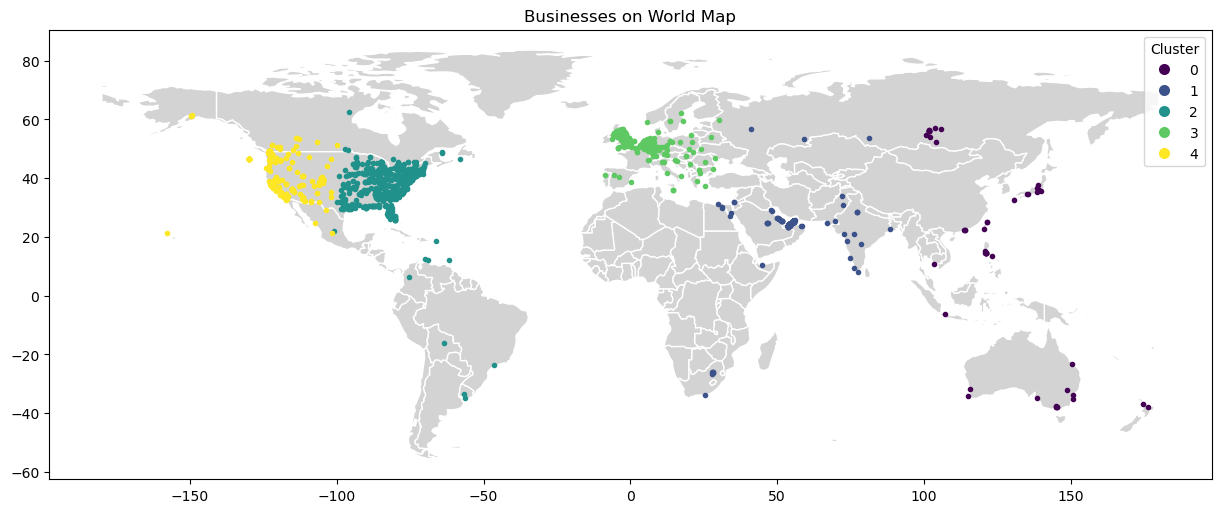

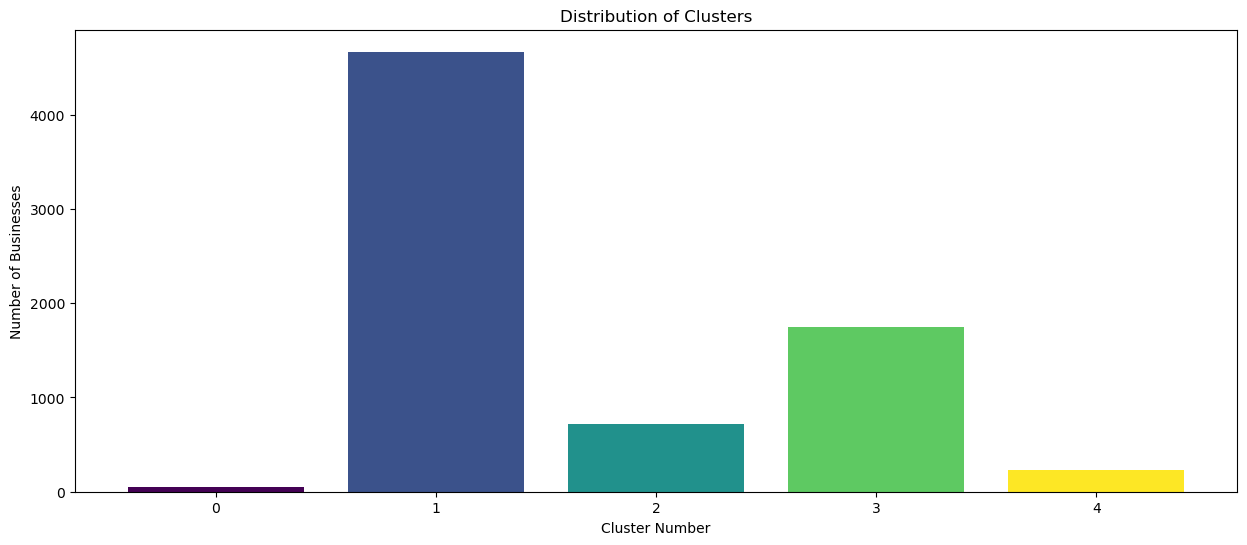

In [121]:
category_colors = createColorMap(labels)
drawMap(X_train, labels, category_colors)
CountClusters(labels, category_colors)

In [ ]:
calculateScores(X_train, labels)

#### KMedoids

In [80]:
medoids_model = KMedoids(n_clusters=5, random_state=0)
medoids_model.fit(X_train)
labels = medoids_model.predict(X_train)

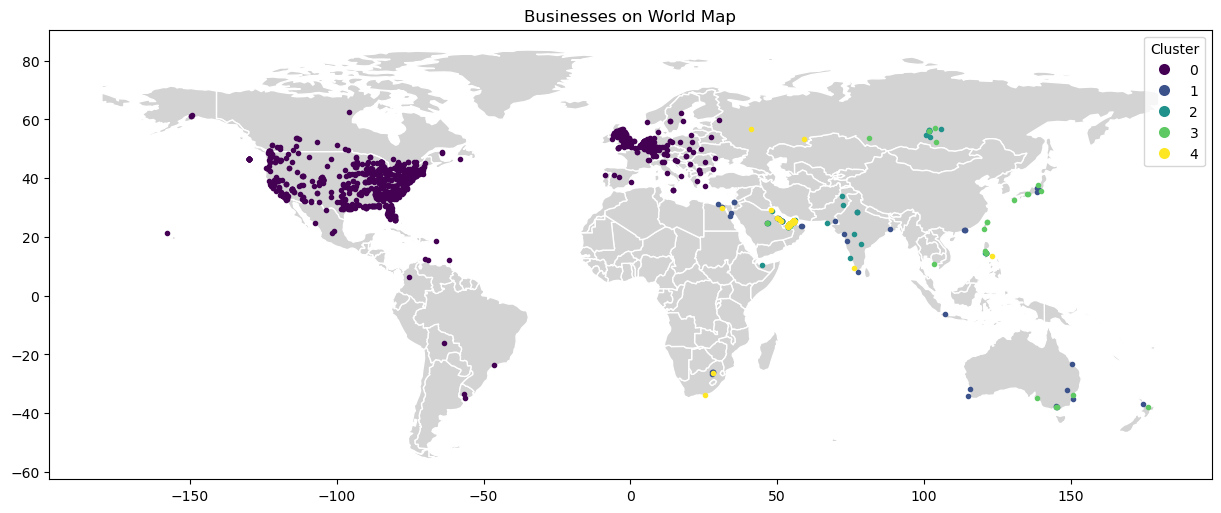

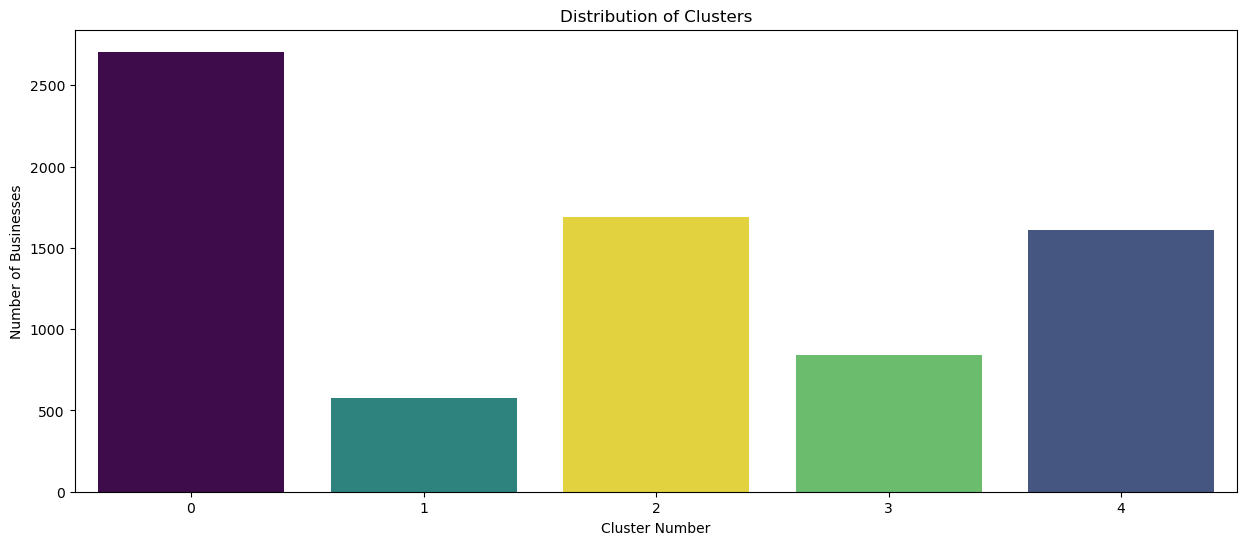

In [81]:
drawMap(X_train, labels)
CountClasters(labels)

In [11]:
calculateScores(X_train, labels)

,Score name,score value
0,Silhouette Score,0.138568
1,Calinski-Harabaz Index,3781.078788
2,Davies-Bouldin Index,2.608965


### Hierarchic models

In [12]:
def linkageGraph(data, method):
    Z = hierarchy.linkage(data, method=method)
    plt.figure(figsize=(10, 20), dpi= 200, facecolor='w', edgecolor='k')
    hierarchy.dendrogram(Z)
    plt.show()
    return Z

#### Single Linkage

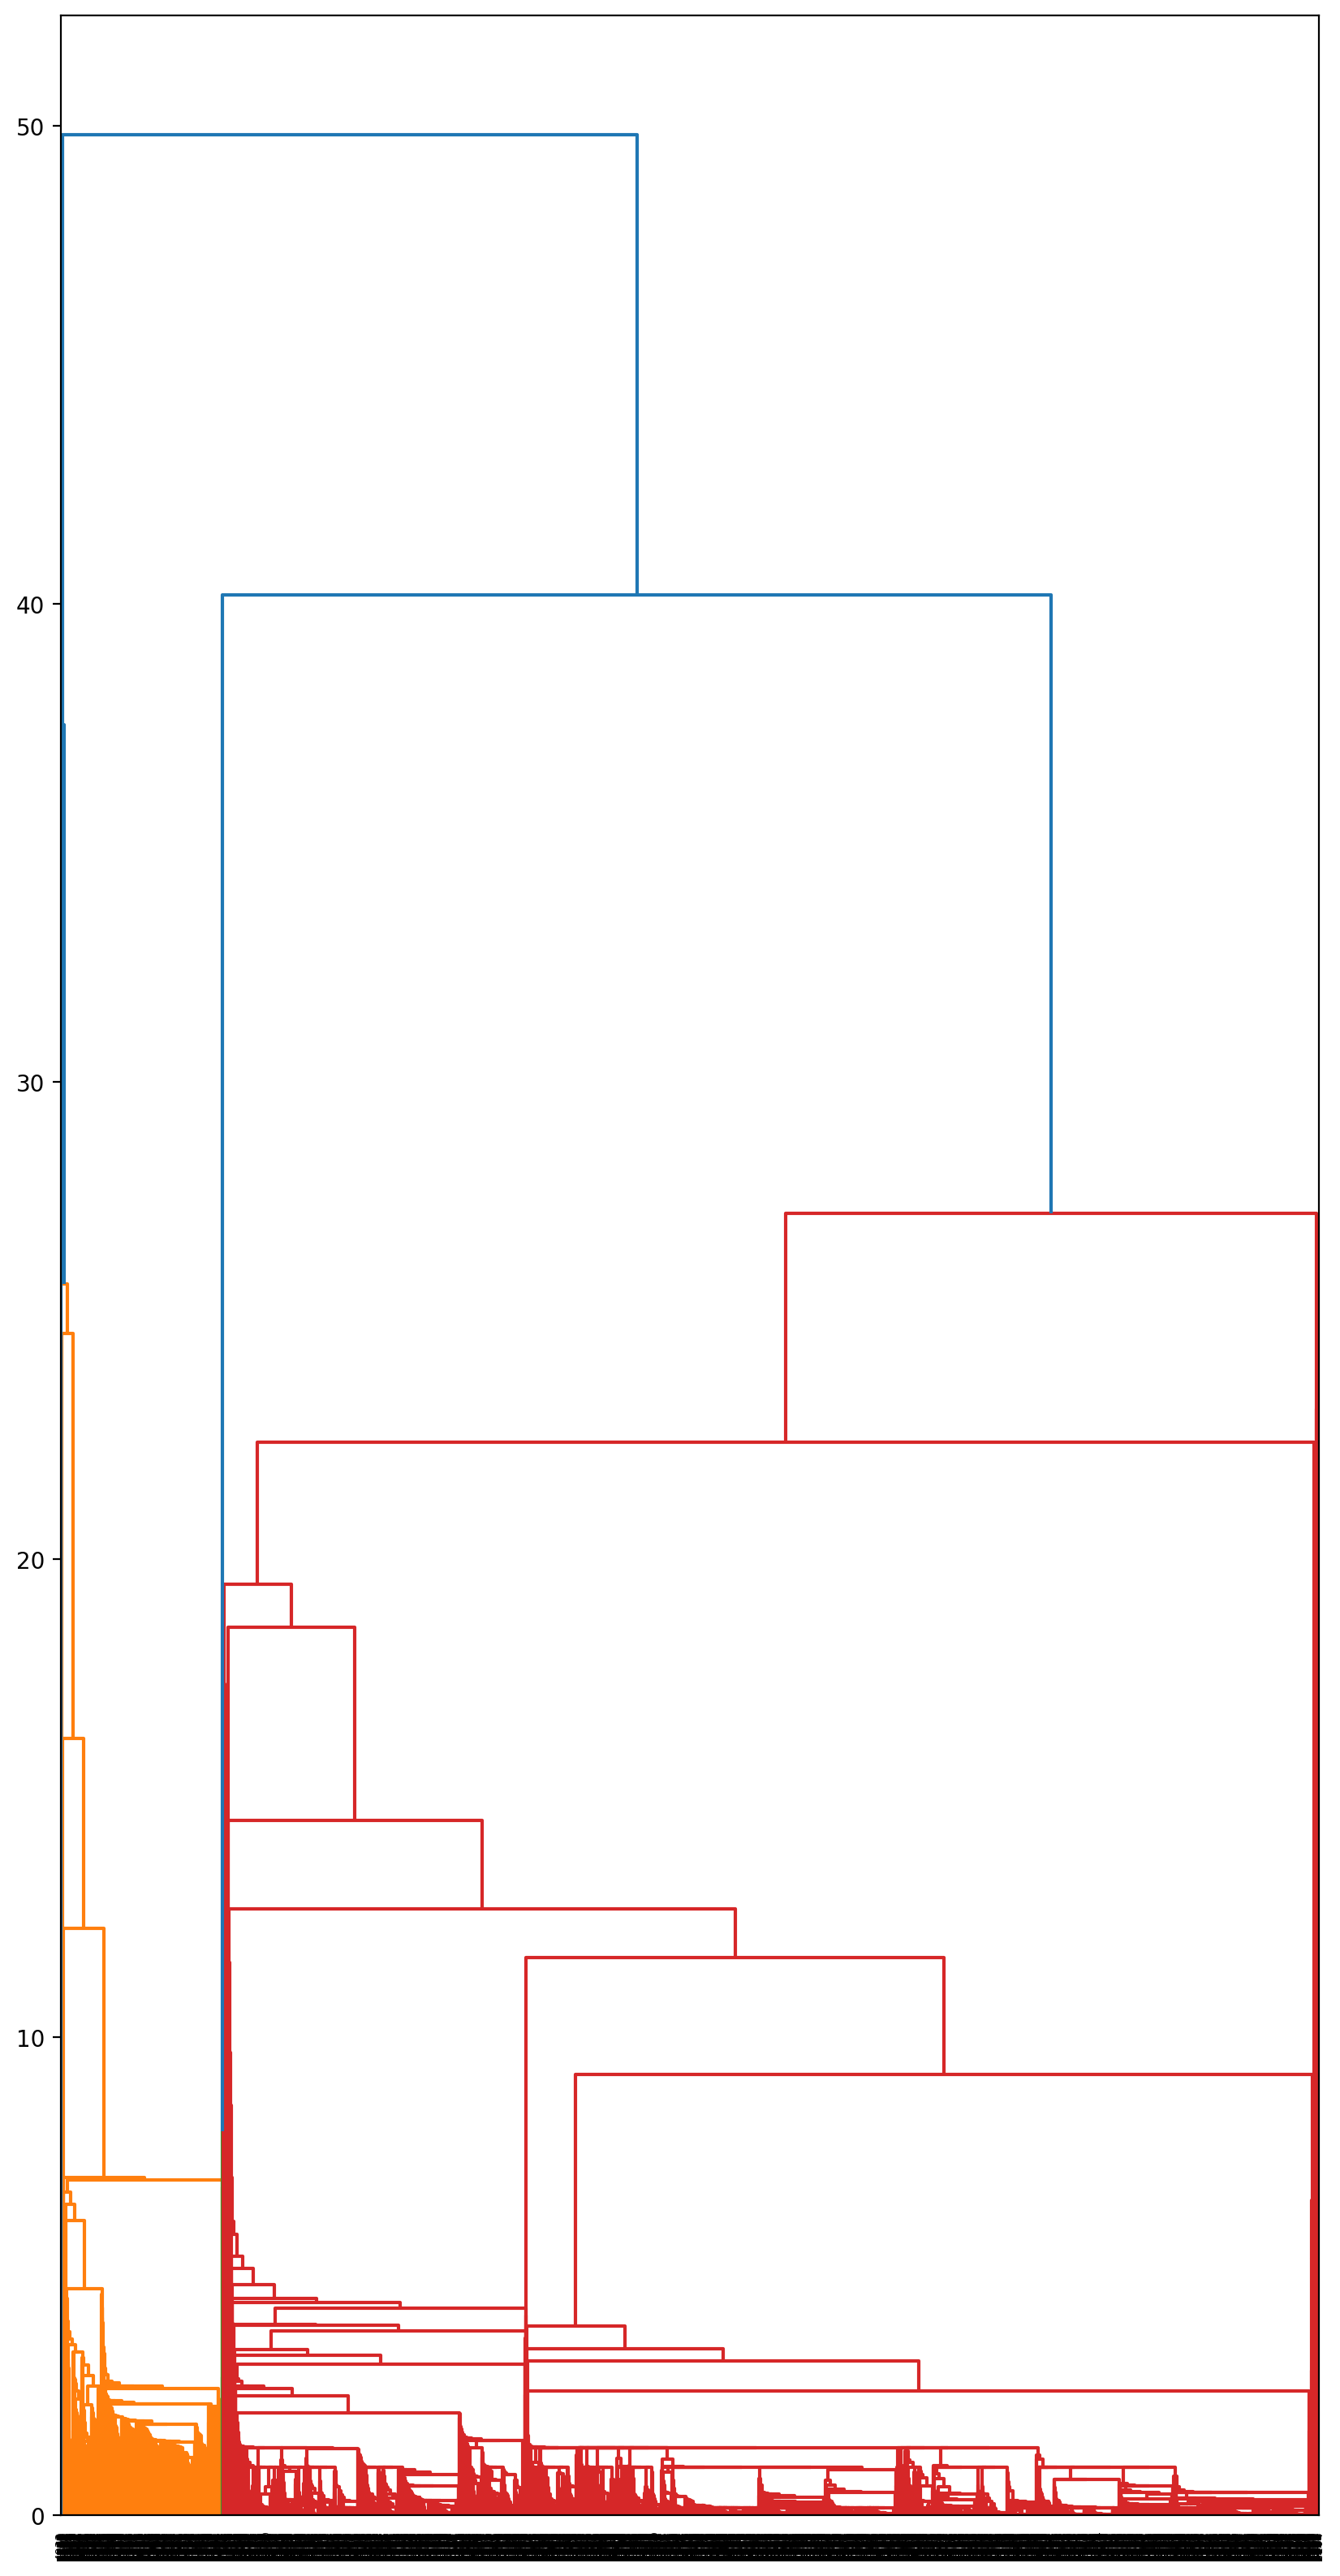

In [13]:
Z = linkageGraph(X_train, 'single')

In [14]:
model = AgglomerativeClustering(n_clusters=None, linkage='single', distance_threshold=25)
labels = model.fit_predict(X_train)

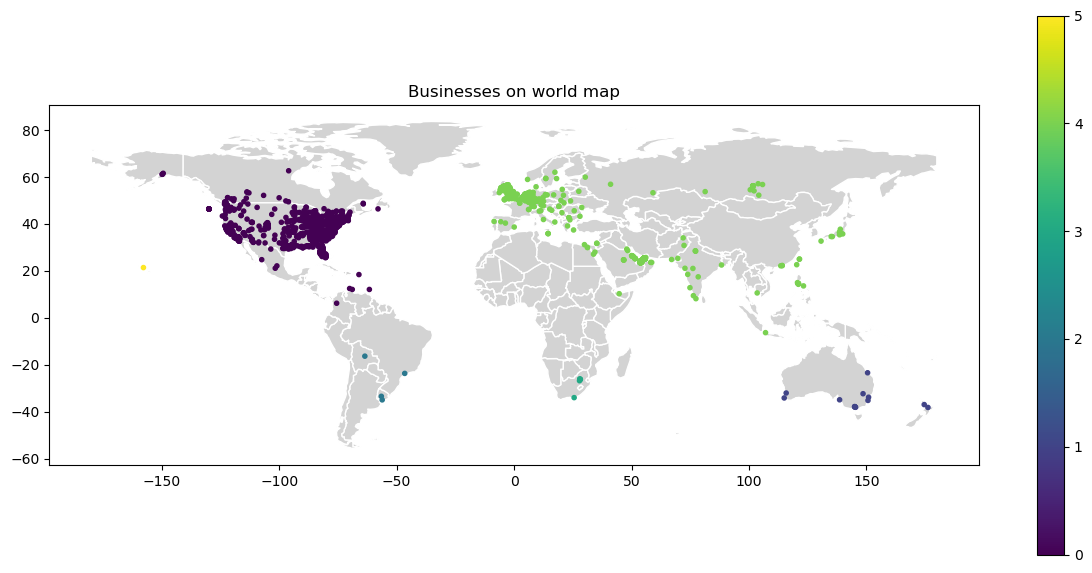

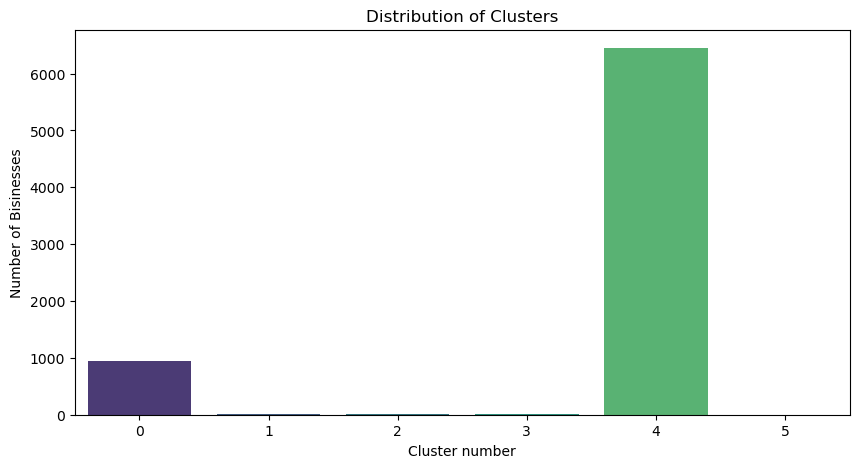

In [15]:
drawMap(X_train, labels)
CountClasters(labels)

In [16]:
calculateScores(X_train, labels)

,Score name,score value
0,Silhouette Score,0.634109
1,Calinski-Harabaz Index,4640.509838
2,Davies-Bouldin Index,0.333668


#### Complete Linkage

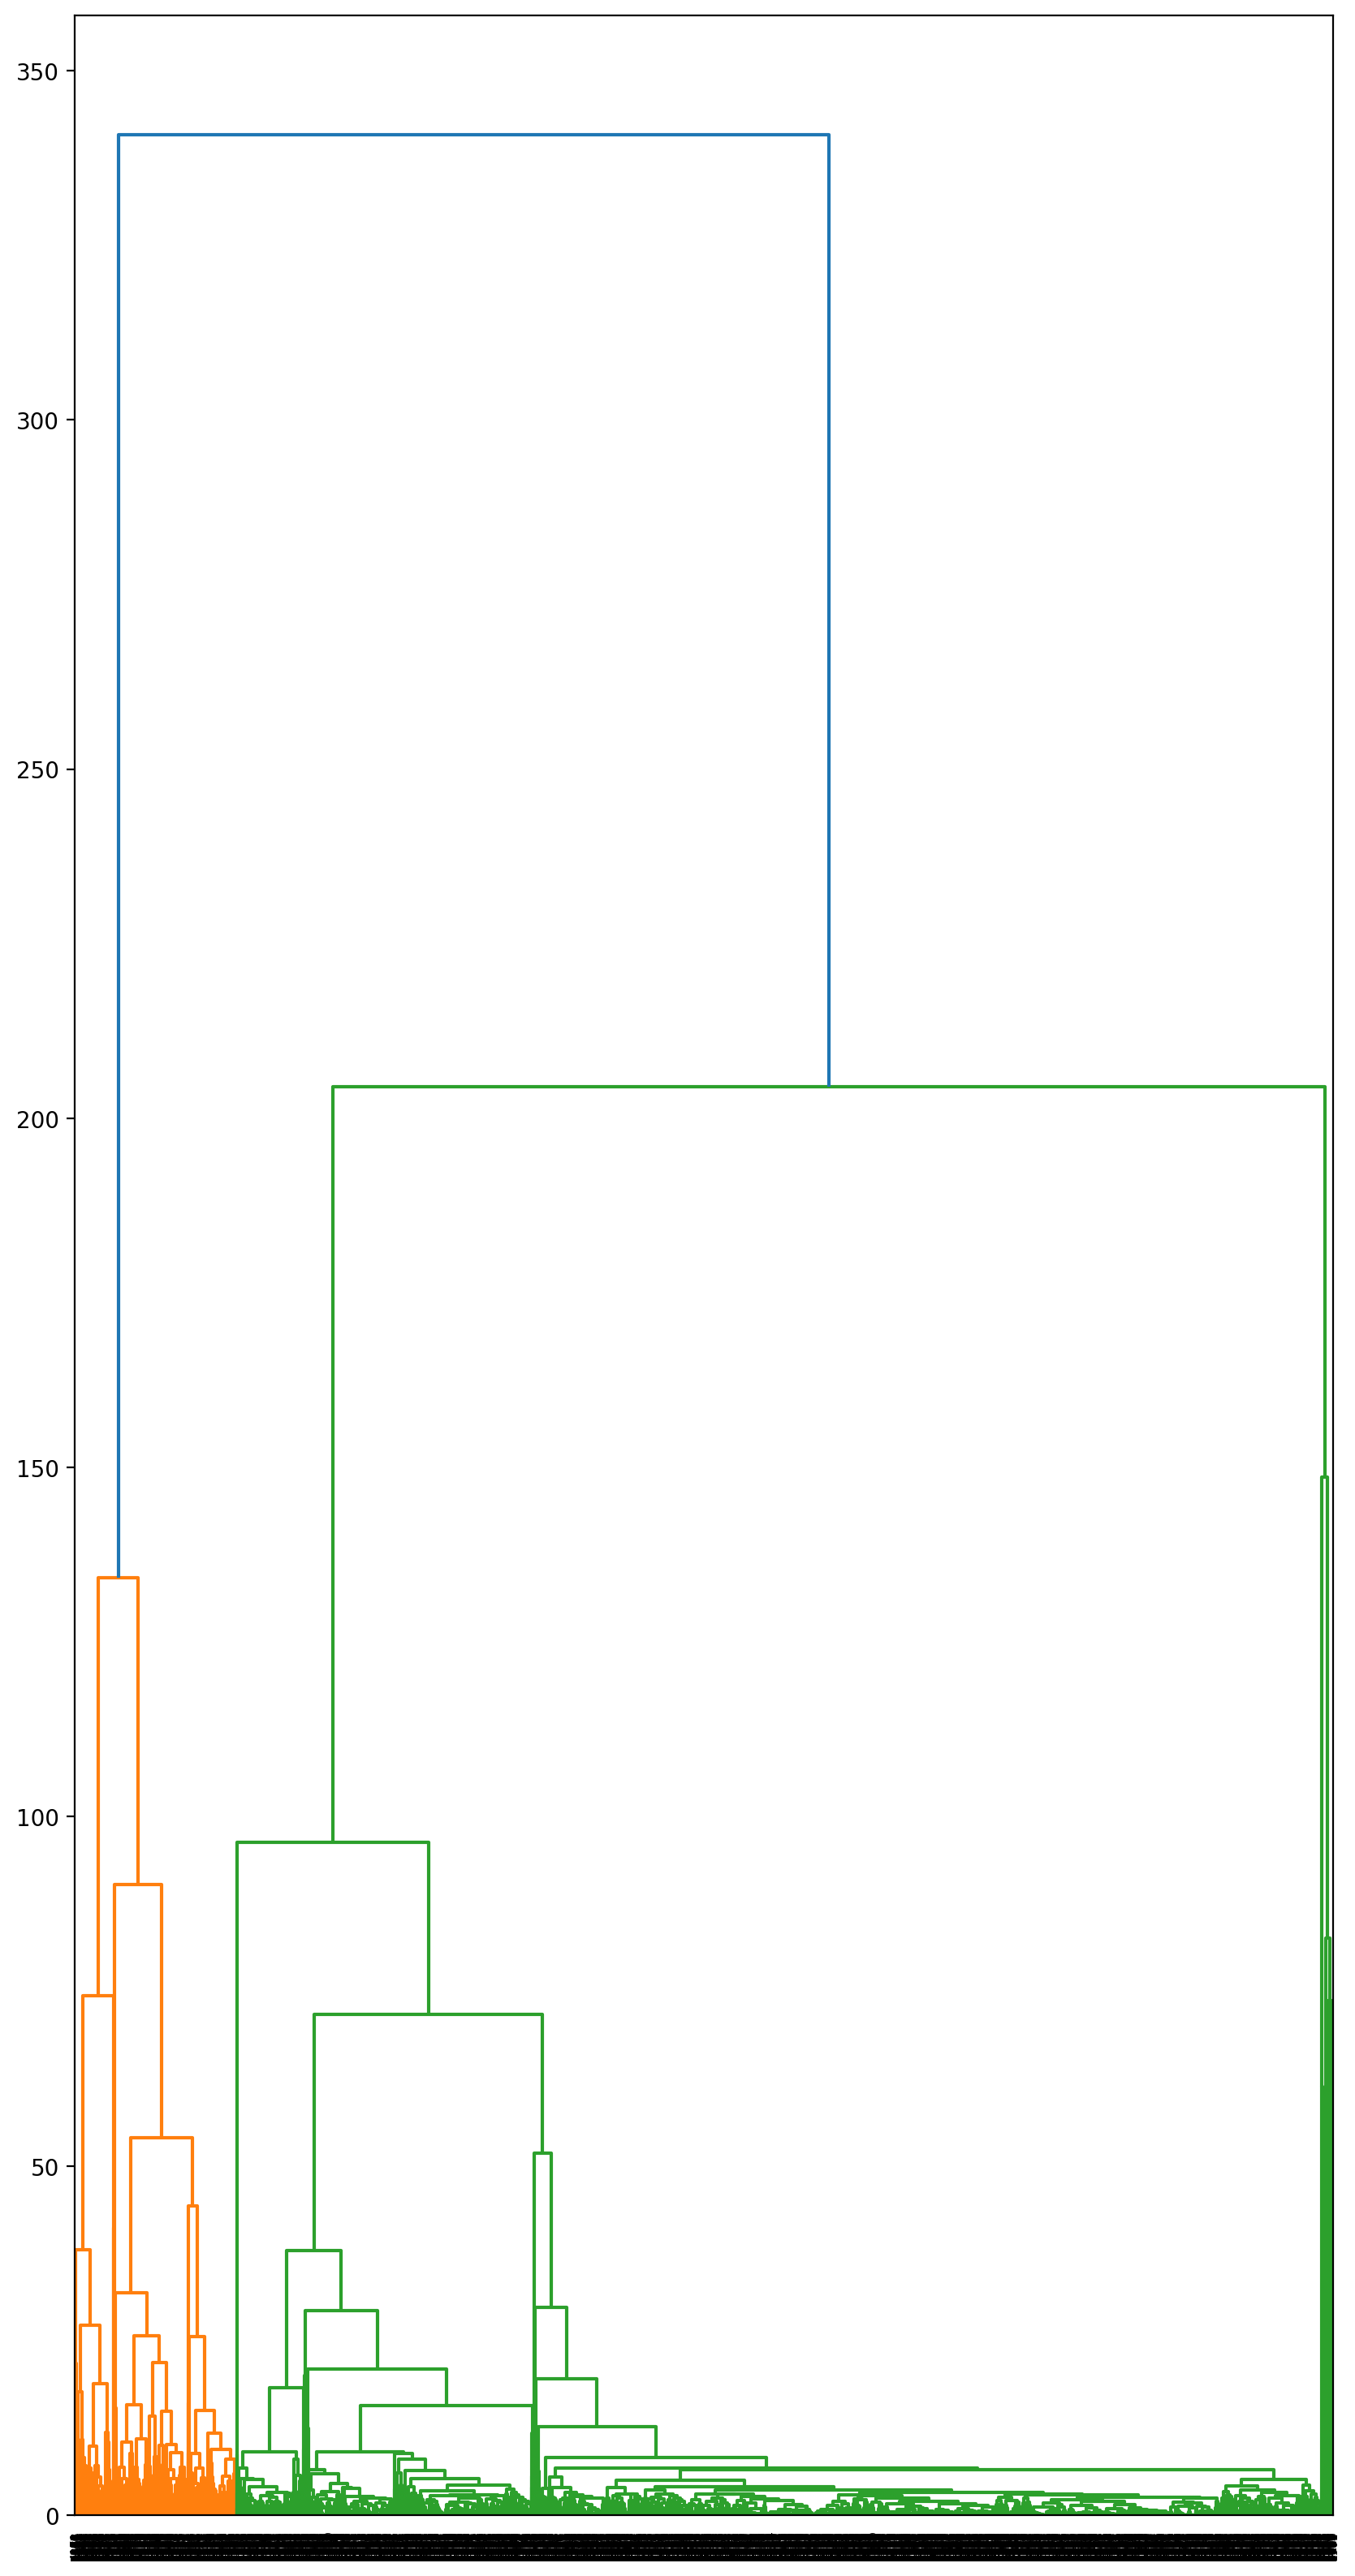

In [17]:
Z = linkageGraph(X_train, 'complete')

In [18]:
model = AgglomerativeClustering(n_clusters=None, linkage='complete', distance_threshold=150)
labels = model.fit_predict(X_train)

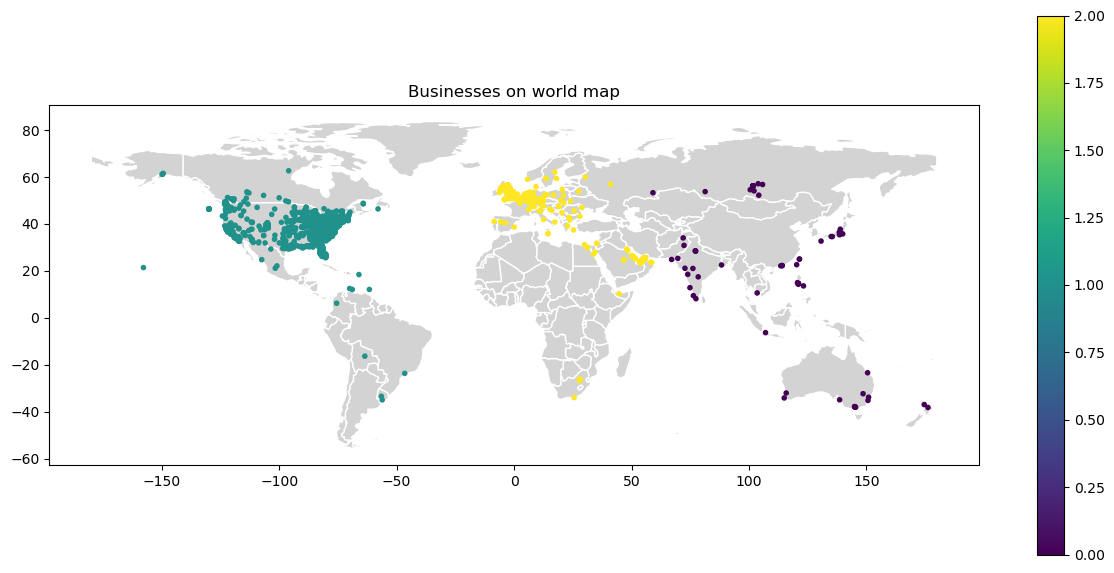

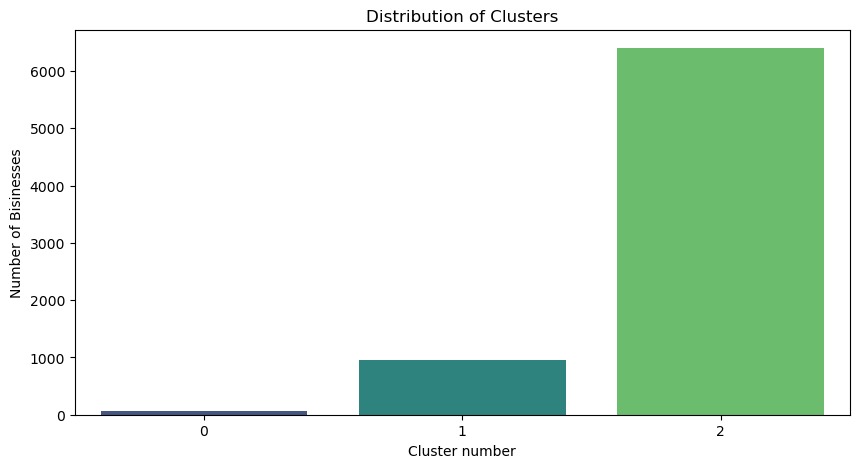

In [19]:
drawMap(X_train, labels)
CountClasters(labels)

In [20]:
calculateScores(X_train, labels)

,Score name,score value
0,Silhouette Score,0.693281
1,Calinski-Harabaz Index,11908.824970
2,Davies-Bouldin Index,0.641742


#### Average Linkage

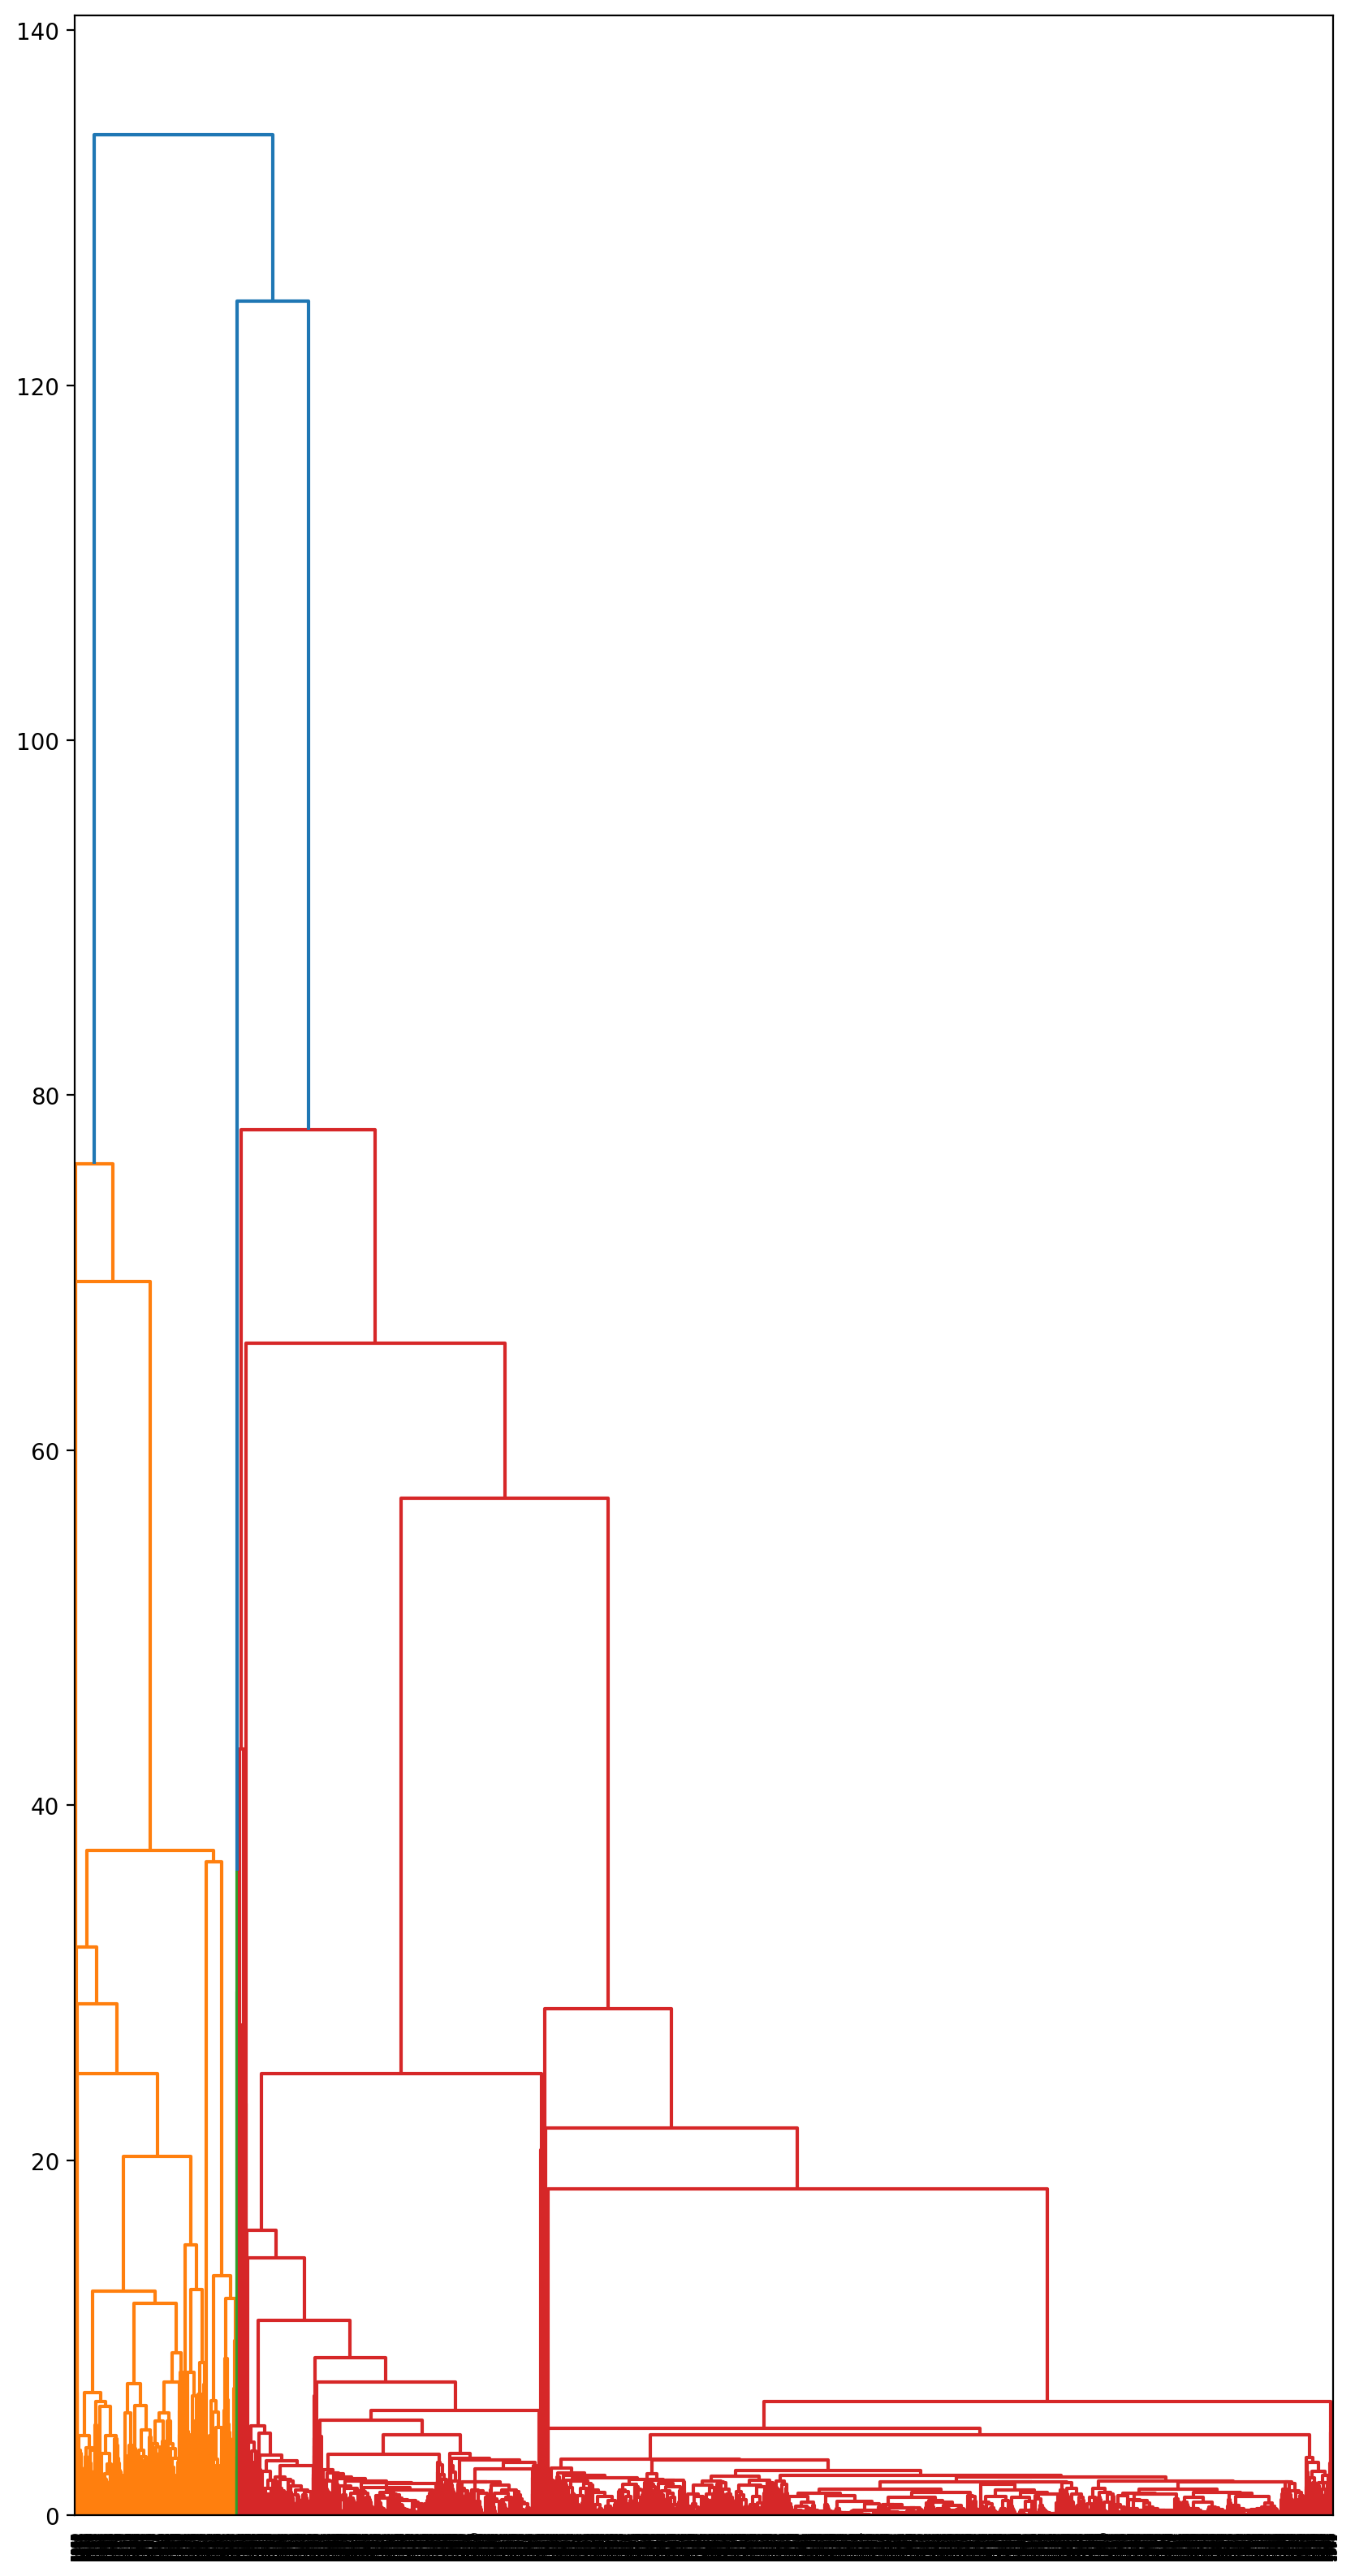

In [21]:
Z = linkageGraph(X_train, 'average')

In [22]:
model = AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=100)
labels = model.fit_predict(X_train)

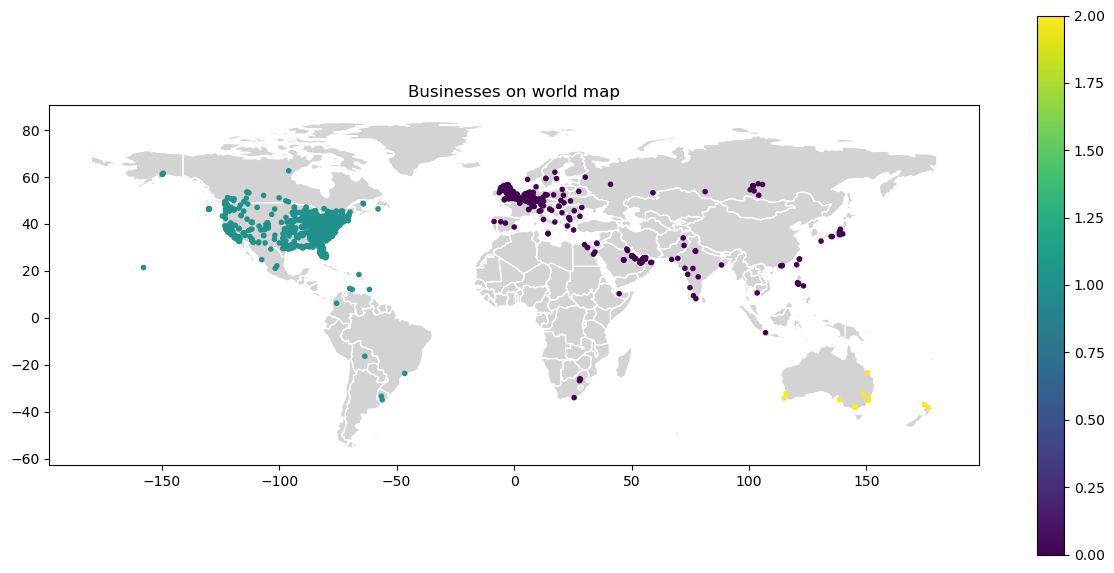

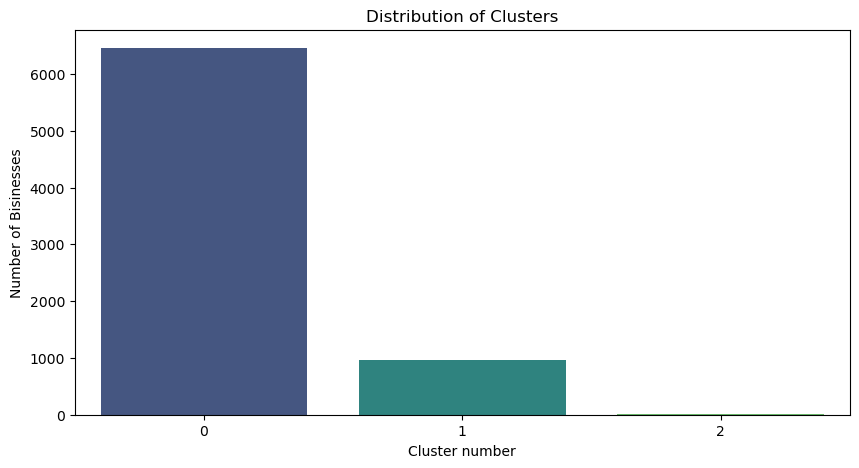

In [23]:
drawMap(X_train, labels)
CountClasters(labels)

In [24]:
calculateScores(X_train, labels)

,Score name,score value
0,Silhouette Score,0.762862
1,Calinski-Harabaz Index,11449.099464
2,Davies-Bouldin Index,0.288405


#### Ward's Linkage

In [25]:
Z = linkageGraph(X_train, 'ward')


KeyboardInterrupt



In [ ]:
model = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=800)
labels = model.fit_predict(X_train)

In [ ]:
drawMap(X_train, labels)
CountClasters(labels)

In [ ]:
calculateScores(X_train, labels)